In [17]:
import pandas as pd

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice
import random
import numpy as np
import torch

In [3]:
from pytorch_lightning.loggers import CSVLogger

In [4]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger

from estimator import LagGPTEstimator

In [5]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [6]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [7]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds)

In [8]:
# dataset = get_dataset("electricity").train

In [9]:
val_dataset = get_dataset("traffic").train

In [10]:
test_dataset = get_dataset("m4_weekly").test

In [11]:
meta = get_dataset("m4_weekly").metadata

In [12]:
meta

MetaData(freq='W', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='359')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=13)

In [13]:
#set more seeds

In [14]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logger = CSVLogger("logs", name="Lag-gpt-large-"+str(seed))

In [15]:
!unset LD_LIBRARY_PATH

In [16]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=4, # 4
    n_layer=8,
    n_head=4,
    n_embd=2048, # 256,1024,2048 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="32", logger=logger),
)

In [17]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 411 M 
--------------------------------------
411 M     Trainable params
0         Non-trainable params
411 M     Total params
1,645.044 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached -1.58372 (best -1.58372), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' reached -1.79092 (best -1.79092), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' reached -1.99179 (best -1.99179), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' reached -2.28347 (best -2.28347), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' reached -2.29160 (best -2.29160), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=13-step=1400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' reached -2.40714 (best -2.40714), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=15-step=1600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' reached -2.43645 (best -2.43645), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=35-step=3600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' reached -2.52143 (best -2.52143), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=48-step=4900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' reached -2.54582 (best -2.54582), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=50-step=5100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' reached -2.55224 (best -2.55224), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=51-step=5200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' reached -2.57807 (best -2.57807), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=57-step=5800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' reached -2.60539 (best -2.60539), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=69-step=7000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' was not in top 1
Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' reached -2.66115 (best -2.66115), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=93-step=9400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' reached -2.71271 (best -2.71271), saving model to 'logs/Lag-gpt-large-42/version_4/checkpoints/epoch=97-step=9800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [19]:
forecasts = list(forecast_it)

In [20]:
tss = list(ts_it)

In [21]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)

Running evaluation: 100%|██████████| 359/359 [00:01<00:00, 335.34it/s]


In [22]:
agg_metrics

{'MSE': 9969612.113533027,
 'abs_error': 7366101.9279174805,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 28.42205827335383,
 'MAPE': 0.2988834578008296,
 'sMAPE': 0.2726626752296837,
 'MSIS': 849.5236802353385,
 'QuantileLoss[0.1]': 2619066.44274292,
 'Coverage[0.1]': 0.2607670880651382,
 'QuantileLoss[0.2]': 4025790.6657470707,
 'Coverage[0.2]': 0.2991214913220484,
 'QuantileLoss[0.3]': 5249250.0582702635,
 'Coverage[0.3]': 0.32247696593100494,
 'QuantileLoss[0.4]': 6357569.48656006,
 'Coverage[0.4]': 0.34368973644739664,
 'QuantileLoss[0.5]': 7366101.871582031,
 'Coverage[0.5]': 0.3642596957360188,
 'QuantileLoss[0.6]': 8281175.587304687,
 'Coverage[0.6]': 0.38054424683951144,
 'QuantileLoss[0.7]': 9059906.65803833,
 'Coverage[0.7]': 0.40047139490036426,
 'QuantileLoss[0.8]': 9669441.968884278,
 'Coverage[0.8]': 0.42725519605742457,
 'QuantileLoss[0.9]': 9953448.799456786,
 'Coverage[0.9]': 0.4683951146

In [23]:
metric_type = []
error = []
for state in agg_metrics:
    metric_type.append(state)
for value in agg_metrics.values():
    error.append(value)

In [24]:
df = pd.DataFrame( error, metric_type).reset_index().rename(columns = {'index': 'error',0:'metric_type'}).T
df.columns = df.iloc[0,:]
df = df.iloc[1:, :]
df['#parameters']=411000000#102000000#411000000#6800000
df['seed'] = seed
# df.to_csv('error100.csv')

In [25]:
dff = pd.read_csv('error100.csv')#.drop('Unnamed: 0', axis=1)
# dff.columns
dff = dff.append(df)
dff.to_csv('error100.csv', index=False)

/tmp/ipykernel_86/941960961.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df)


In [ ]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

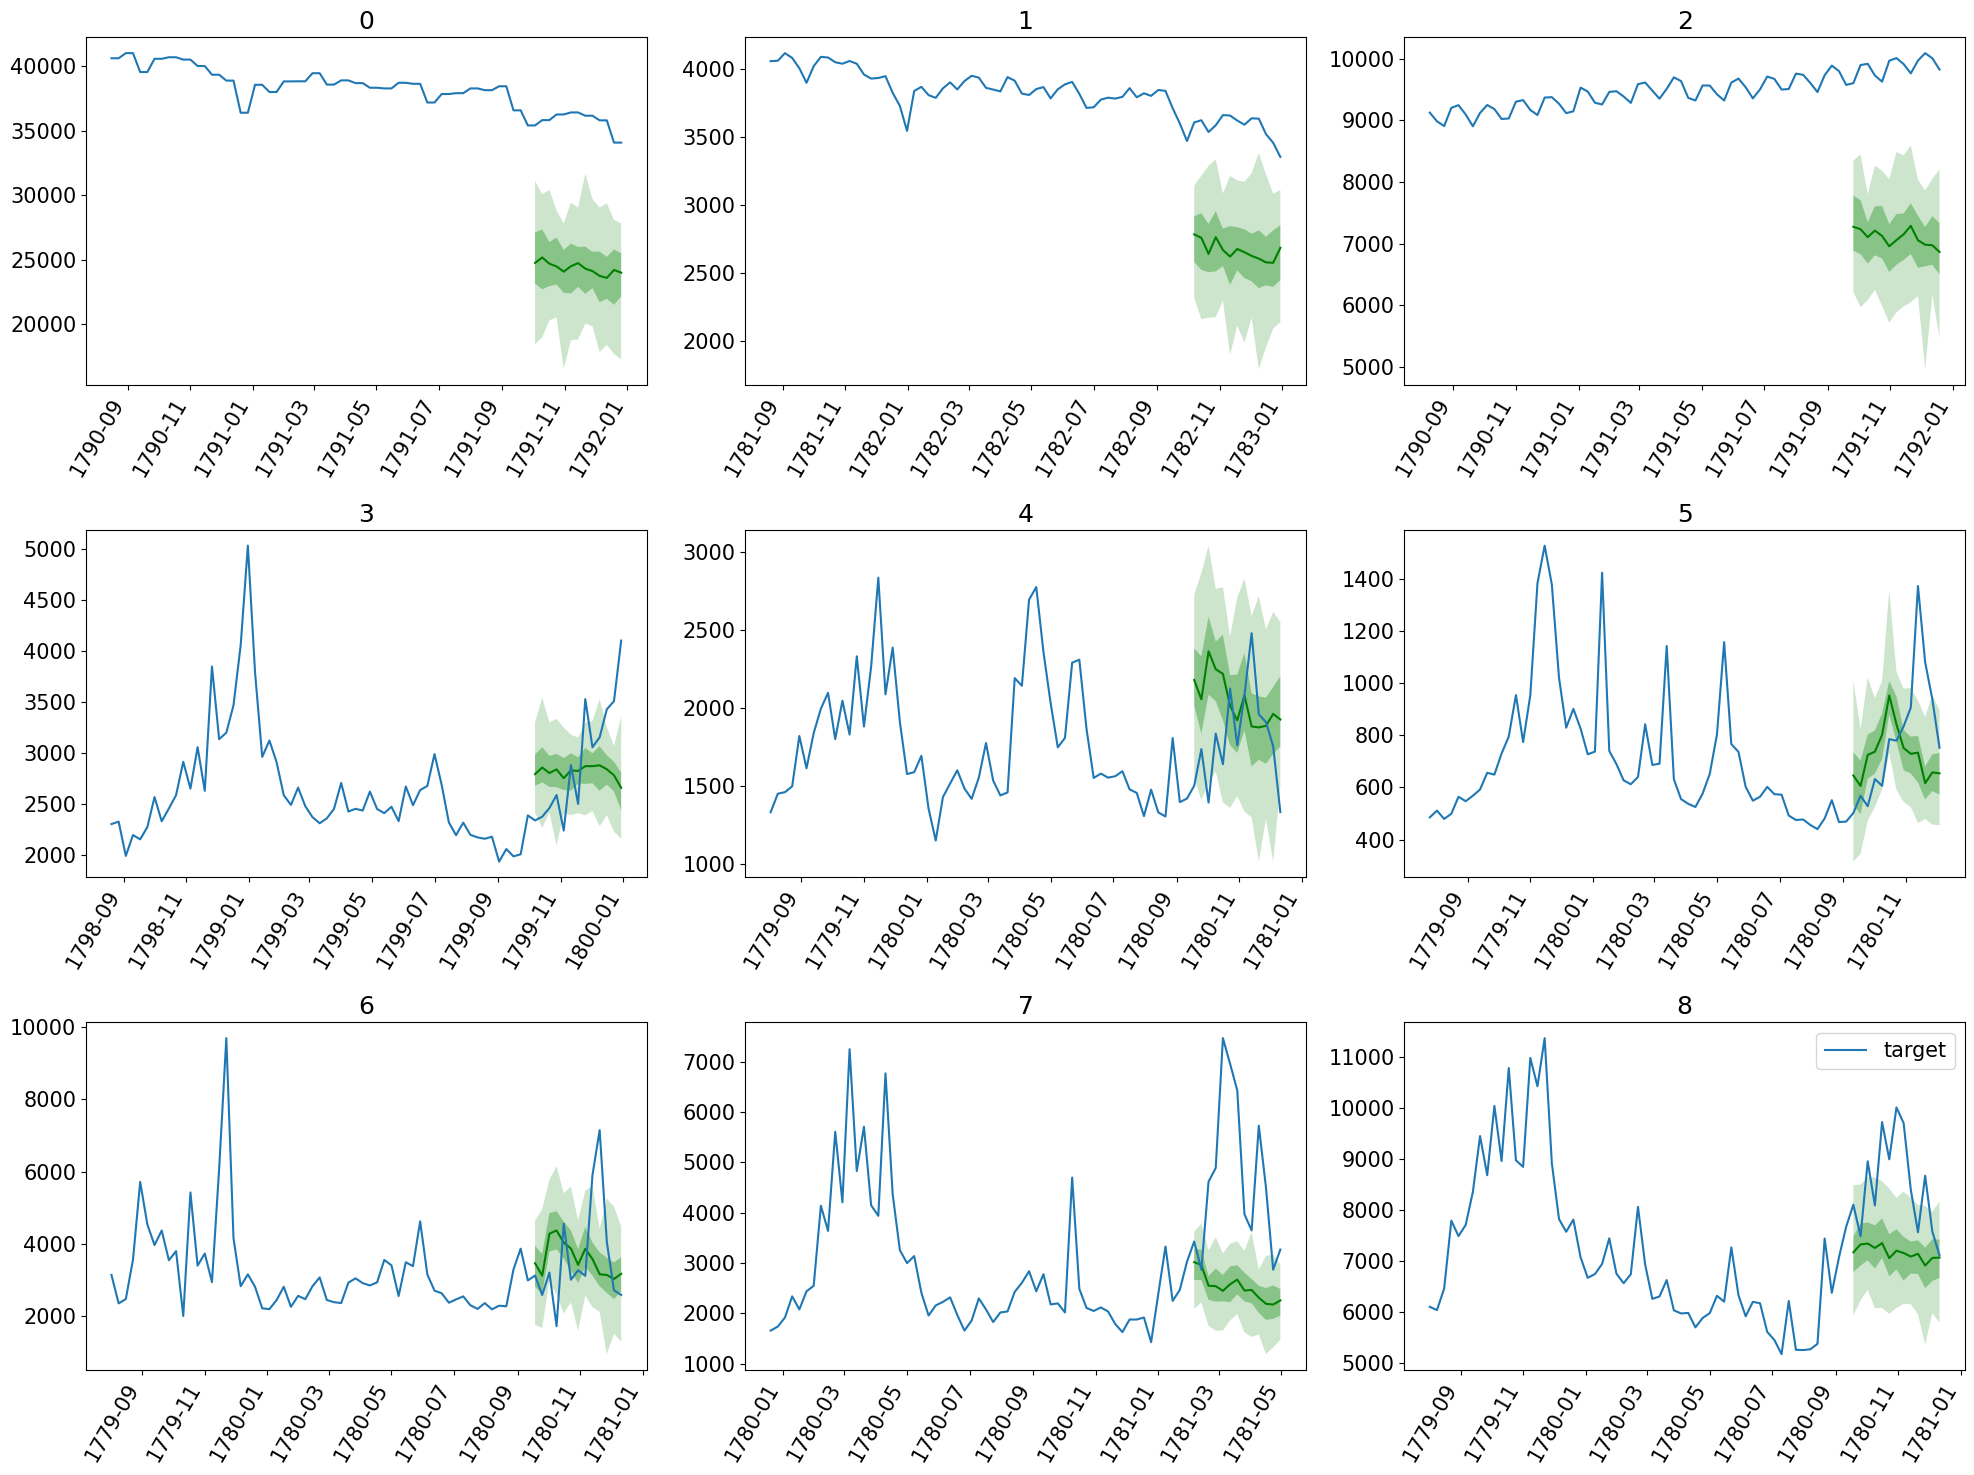

In [68]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [10]:
# beam
agg_metrics

{'MSE': 2353700.5849478617,
 'abs_error': 10347671.897188187,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8922449918745382,
 'MAPE': 0.11220455807131616,
 'sMAPE': 0.1165269710200355,
 'MSIS': 12.069460309886567,
 'QuantileLoss[0.1]': 4623474.5003027115,
 'Coverage[0.1]': 0.15873015873015875,
 'QuantileLoss[0.2]': 6818143.679625946,
 'Coverage[0.2]': 0.23221703011422637,
 'QuantileLoss[0.3]': 8406636.595204707,
 'Coverage[0.3]': 0.29175938288087816,
 'QuantileLoss[0.4]': 9575201.4348929,
 'Coverage[0.4]': 0.34625797359442223,
 'QuantileLoss[0.5]': 10347671.921518601,
 'Coverage[0.5]': 0.4009790832220739,
 'QuantileLoss[0.6]': 10781971.85629762,
 'Coverage[0.6]': 0.45202863076694855,
 'QuantileLoss[0.7]': 10792582.533077706,
 'Coverage[0.7]': 0.5083815457647234,
 'QuantileLoss[0.8]': 10251792.43568935,
 'Coverage[0.8]': 0.579105473965287,
 'QuantileLoss[0.9]': 8707283.513710178,
 'Coverage[0.9]': 0.669707758492

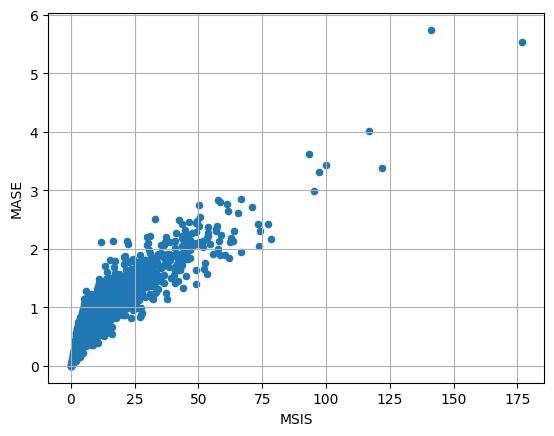

In [11]:
ts_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

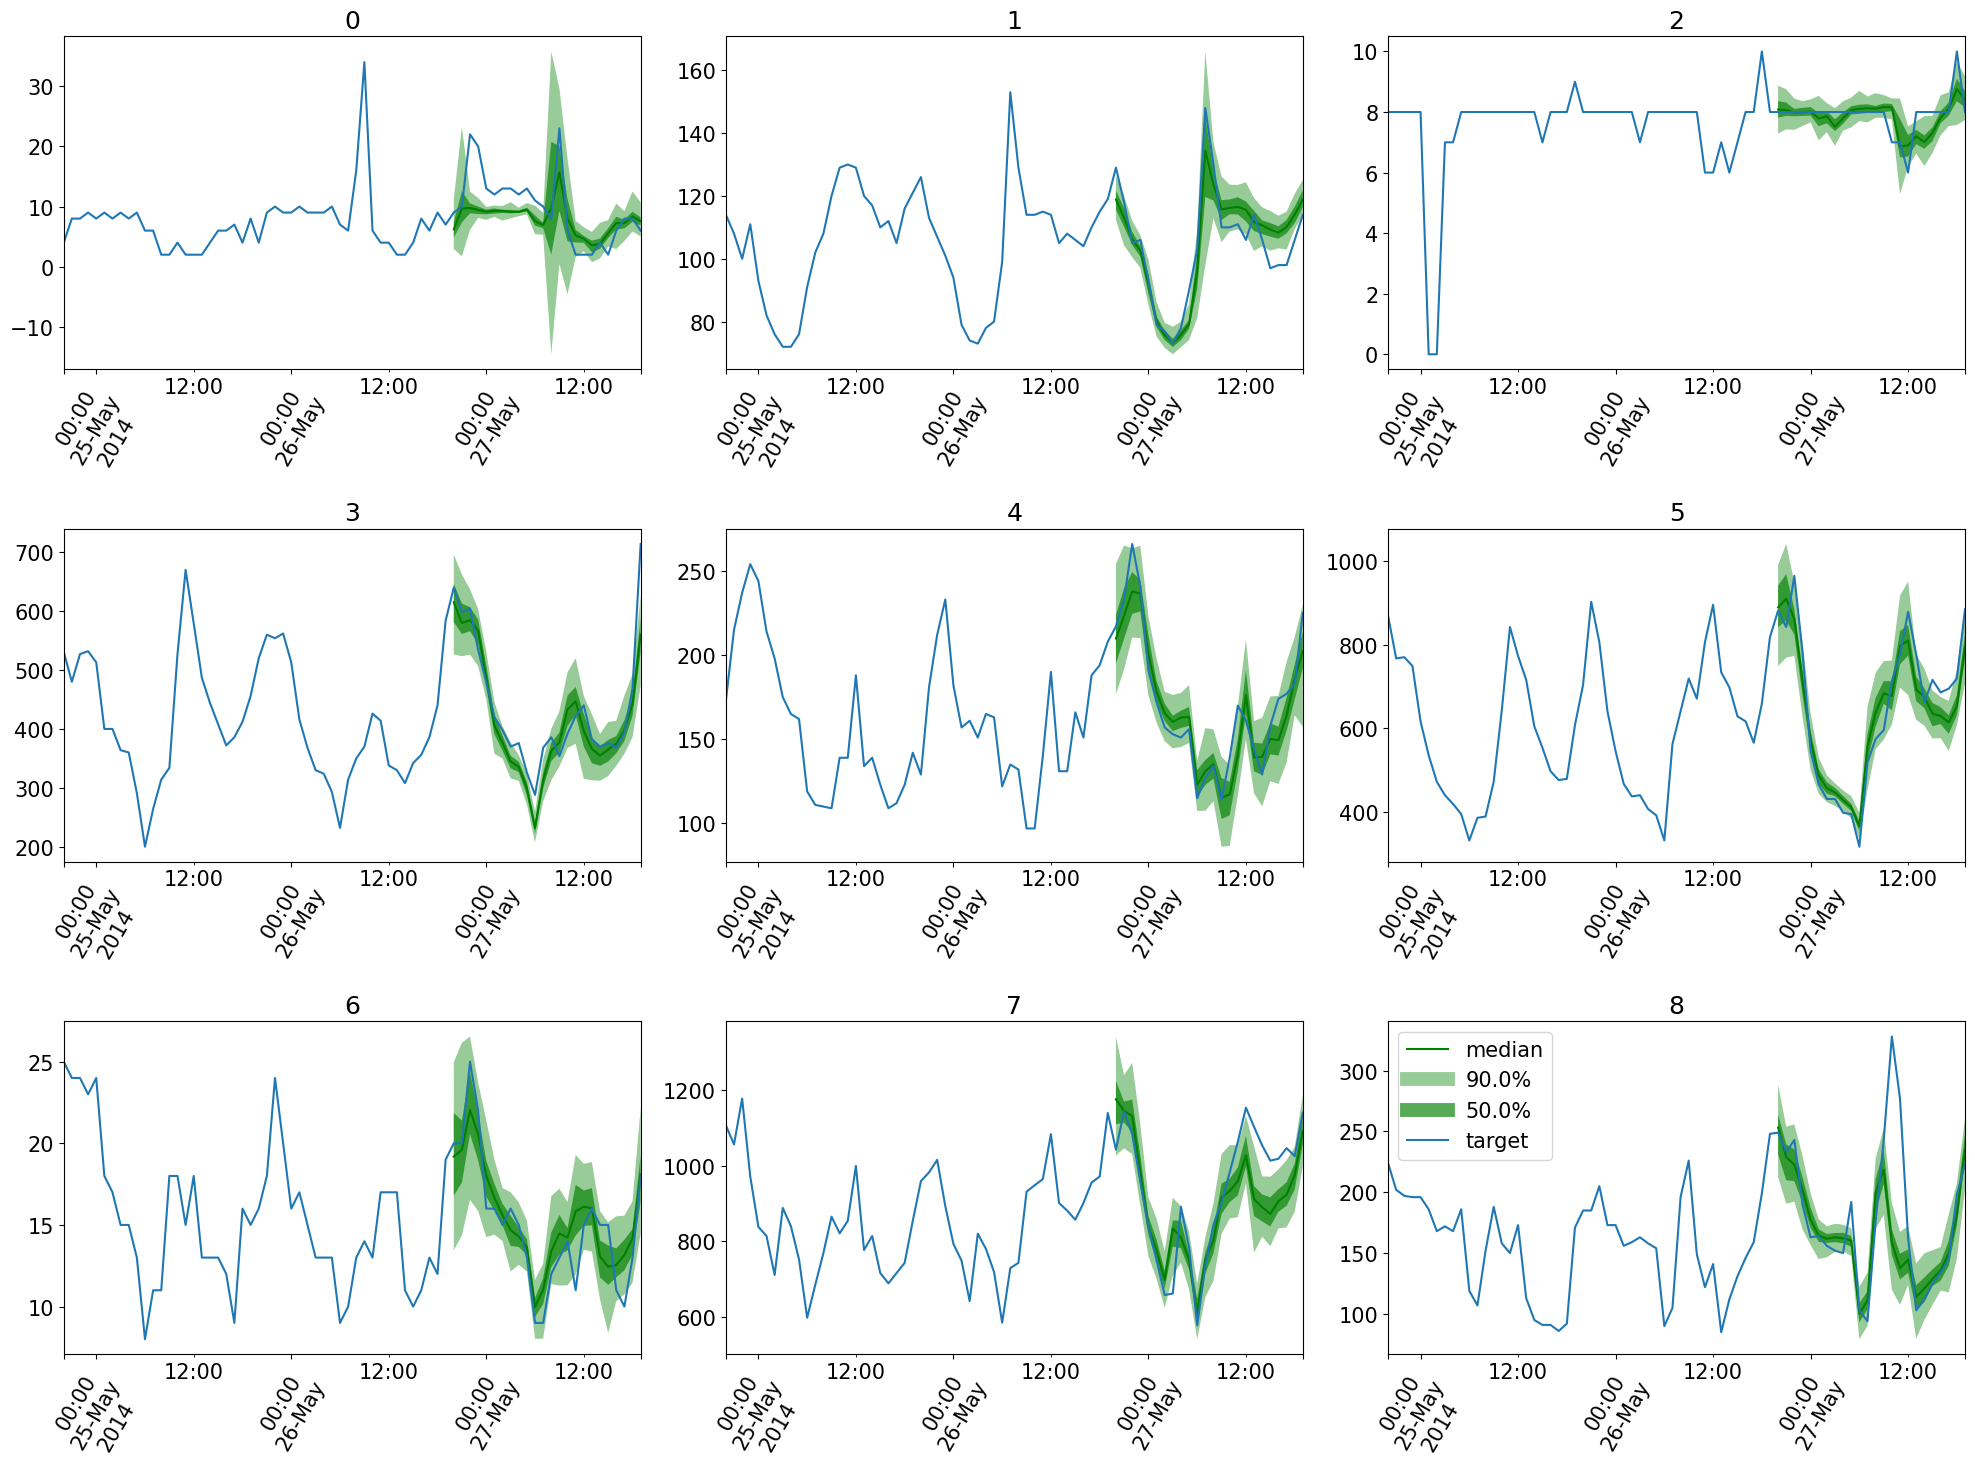

In [12]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * dataset.metadata.prediction_length:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [64]:
df = pd.read_csv('error100.csv')
df = df.drop_duplicates(subset=['#parameters','seed'], keep='last')
temp = df.groupby(['#parameters'])['RMSE'].mean().reset_index().dropna()
std_temp = df.groupby(['#parameters'])['RMSE'].std().reset_index()

In [5]:
temp

,#parameters,RMSE
0,6800000,2466.040116
1,102000000,2932.038090
2,411000000,2894.099543


In [7]:
std_temp

,#parameters,RMSE
0,6800000,461.104073
1,102000000,600.143683
2,411000000,821.005547


<Figure size 640x480 with 0 Axes>

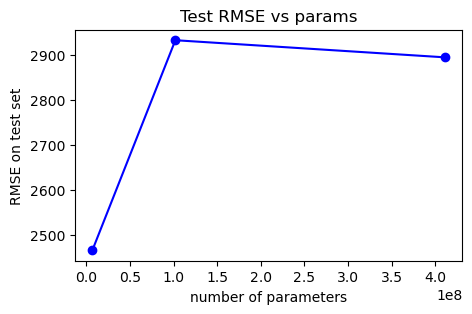

In [65]:
plt.clf()
fig = plt.subplots(figsize =(5, 3))# large

# plt.bar(temp['model'],temp['crps'],width = 0.2)
plt.plot(temp['#parameters'],temp['RMSE'],'bo-')
for x,y in zip(np.log10(temp['#parameters']),[0,0.1,0.5]):

    label = f"p={y}"

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
plt.title('Test RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


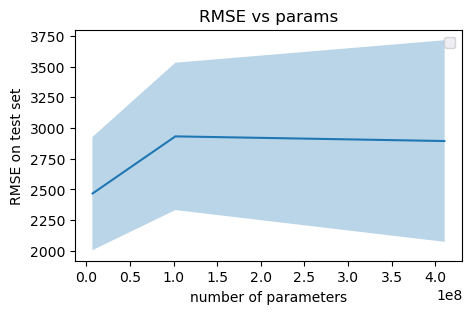

In [66]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,3))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    ax.plot(temp['#parameters'], temp['RMSE'])
    ax.fill_between(temp['#parameters'], temp['RMSE']-std_temp['RMSE'], temp['RMSE']+std_temp['RMSE'] ,alpha=0.3)
    ax.legend()
plt.title('RMSE vs params')
plt.xlabel('number of parameters')
plt.ylabel('RMSE on test set')
plt.show()
    # ax.set_yscale('log')

In [41]:
import os
path = "logs/"
dir_list = os.listdir(path)
dir_list

['Lag-gpt-medium-1000',
 'Lag-gpt-medium-0',
 'Lag-gpt-small-42',
 'Lag-gpt-small-0',
 'Lag-gpt-small-10',
 'Lag-gpt-medium-10',
 'Lag-gpt-small-1000',
 'Lag-gpt-large-0',
 'Lag-gpt-medium-42',
 'Lag-gpt-large-100',
 'Lag-gpt-medium-100',
 'Lag-gpt-large-1000',
 'Lag-gpt-large-42',
 'Lag-gpt-small-100',
 'Lag-gpt-large-10']

In [67]:
dff = pd.DataFrame()
for i in dir_list:
    
    df = pd.read_csv('logs/'+i+'/version_0/metrics.csv').drop(['train_loss'], axis=1).dropna()
    df['seed']=int(i.split("-")[-1])
    if i.split("-")[-2]=='medium':
        df['parameters']=102000000
    if i.split("-")[-2]=='small':
        print(i)
        df['parameters']=6800000
    if i.split("-")[-2]=='large':
        df['parameters']=411000000
    dff = dff.append(df, ignore_index=True)


Lag-gpt-small-42
Lag-gpt-small-0
Lag-gpt-small-10
Lag-gpt-small-1000
Lag-gpt-small-100


/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(df, ignore_index=True)
/tmp/ipykernel_86/1350968285.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [57]:
dff['parameters'].unique().tolist()

[102000000, 6800000, 411000000]

In [69]:
temp = dff.groupby(['parameters','epoch'])['val_loss'].mean().reset_index().dropna()
std_temp = dff.groupby(['parameters','epoch'])['val_loss'].std().reset_index().dropna()


In [70]:
temp

,parameters,epoch,val_loss
0,6800000,0,-1.219659
1,6800000,1,-1.752330
2,6800000,2,-1.638569
3,6800000,3,-2.009745
4,6800000,4,-2.210008
...,...,...,...
295,411000000,95,-2.222825
296,411000000,96,-2.218131
297,411000000,97,-2.303583
298,411000000,98,-2.296423


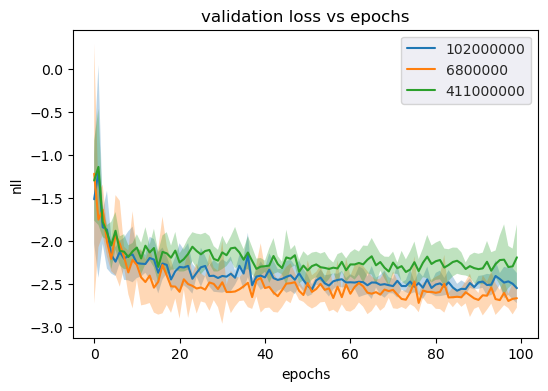

In [71]:
fig, ax = plt.subplots(figsize=(6,4))
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    for i in dff['parameters'].unique().tolist():
        ax.plot(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss'], label=i)
        ax.fill_between(temp[temp['parameters']==i]['epoch'], temp[temp['parameters']==i]['val_loss']-std_temp[std_temp['parameters']==i]['val_loss'], temp[temp['parameters']==i]['val_loss']+std_temp[std_temp['parameters']==i]['val_loss'] ,alpha=0.3)
        ax.legend()
plt.title('validation loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('nll')
plt.show()